## WARNING

Playground для экспериментов и проверок теорий. Не воспринимайте серьезно, не делайте выводов

In [1]:
import pandas as pd
import numpy as np
import wget
import os

urls = ['https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv', 
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv', 
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv']
for filename in os.listdir():
    if 'time_series' in filename:
        os.remove(filename)
for url in urls:
    filename = wget.download(url)

In [2]:
import seaborn as sns
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
def melt_data(data, column):
    df = pd.melt(data.drop(columns=['Province/State', 'Lat', 'Long']), id_vars=['Country/Region'])
    df['variable'] = pd.to_datetime(df['variable'])
    df = df.groupby(['Country/Region', 'variable'])[['value']].sum().reset_index()
    df['value'] = df['value'].apply(lambda x: 0 if x < 0 else x)
    df[column+'_by_day'] = df['value'] - df['value'].shift(1).fillna(0)
    df[column+'_by_day'] = df[column+'_by_day'].apply(lambda x: 0 if x < 0 else x)
    return df.rename(columns={'value': column, 'variable': 'date'})

In [4]:
cases = melt_data(pd.read_csv('time_series_covid19_confirmed_global.csv'), 'cases')
deaths = melt_data(pd.read_csv('time_series_covid19_deaths_global.csv'), 'deaths')
recovered = melt_data(pd.read_csv('time_series_covid19_recovered_global.csv'), 'recovered')

In [5]:
df = cases.merge(deaths, on=['Country/Region', 'date'], how='outer')\
          .merge(recovered, on=['Country/Region', 'date'], how='outer')
df.shape

(11375, 8)

# Приближение данных по России разными кривыми

In [6]:
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

In [7]:
russian_data = df[df['Country/Region']=='Russia']

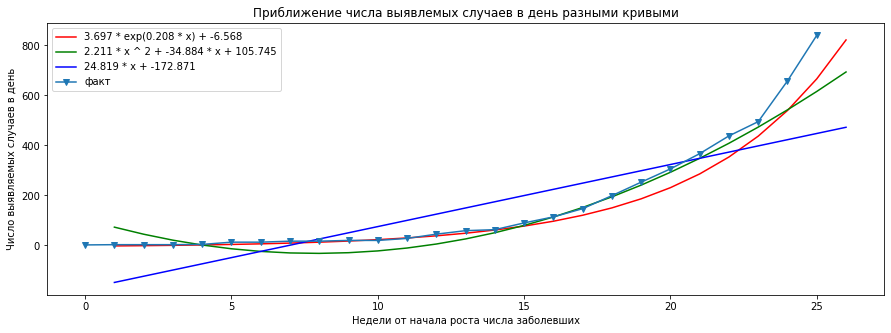

In [14]:
fig, ax1 = plt.subplots(1, 1, figsize=(15,5))

def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c 

ydata = russian_data['cases'].values[39:]

xdata = range(1, len(ydata)+1)

exp_popt, pcov = curve_fit(exp_func, 
                       xdata,
                       ydata)
plt.plot(xdata, exp_func(xdata, *exp_popt), 'r-',label='%5.3f * exp(%5.3f * x) + %5.3f' % tuple(exp_popt))

def quadr_func(l, a, b, c):
    return [a * (x ** 2) + b * x + c for x in l ]

quadr_popt, pcov = curve_fit(quadr_func, 
                       xdata,
                       ydata)
plt.plot(xdata, quadr_func(xdata, *quadr_popt), 'g-',label='%5.3f * x ^ 2 + %5.3f * x + %5.3f' % tuple(quadr_popt))

def line_func(x, a, c):
    return a * x + c

line_popt, pcov = curve_fit(line_func, 
                       xdata,
                       ydata)
plt.plot(xdata, line_func(xdata, *line_popt), 'b-',label='%5.3f * x + %5.3f' % tuple(line_popt))

plt.plot(russian_data['cases'].values[39:], marker='v', label='факт')
plt.legend()
plt.ylabel('Число выявляемых случаев в день')
plt.xlabel('Недели от начала роста числа заболевших')
plt.title('Приближение числа выявлемых случаев в день разными кривыми')
plt.show()

In [9]:
print('R2 score экспоненты: {}'.format(r2_score(ydata, exp_func(xdata, *exp_popt))))
print('R2 score квадратичной функции: {}'.format(r2_score(ydata, quadr_func(xdata, *quadr_popt))))
print('R2 score линейной зависимости: {}'.format(r2_score(ydata, line_func(xdata, *line_popt))))

R2 score экспоненты: 0.9966554708394009
R2 score квадратичной функции: 0.95551593834545
R2 score линейной зависимости: 0.7048658025978518


# Корреляции смертности и выписываемости 

In [10]:
df['Country/Region'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Brunei',
       'Bulgaria', 'Burkina Faso', 'Cabo Verde', 'Cambodia', 'Cameroon',
       'Canada', 'Central African Republic', 'Chad', 'Chile', 'China',
       'Colombia', 'Congo (Brazzaville)', 'Congo (Kinshasa)',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus',
       'Czechia', 'Denmark', 'Diamond Princess', 'Djibouti', 'Dominica',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador',
       'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia',
       'Fiji', 'Finland', 'France', 'Gabon', 'Gambia', 'Georgia',
       'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea',
       'Guinea-Bissau', 'Guyana', 'Haiti', 'H

In [11]:
df.columns

Index(['Country/Region', 'date', 'cases', 'cases_by_day', 'deaths',
       'deaths_by_day', 'recovered', 'recovered_by_day'],
      dtype='object')

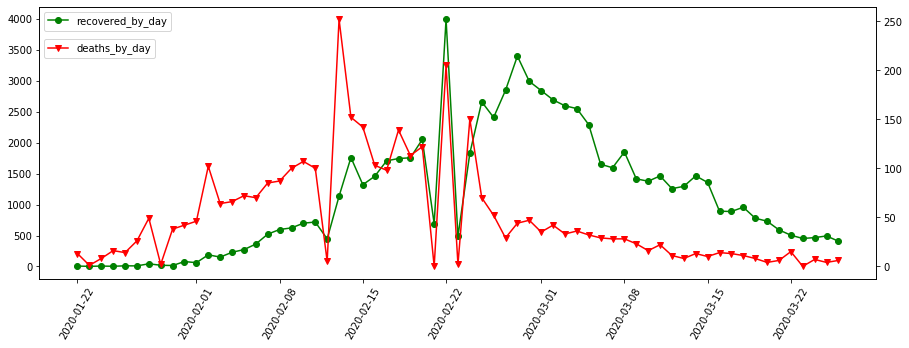

In [12]:
tmp = df[df['Country/Region']=='China']

fig, ax1 = plt.subplots(1, 1, figsize=(15,5))
plt.xticks(rotation=60)
ax1.plot(tmp['date'], tmp['recovered_by_day'], color='green', marker='o')

ax2 = ax1.twinx()
ax2.plot(tmp['date'], tmp['deaths_by_day'], color='red', marker='v')

ax1.legend(['recovered_by_day'], loc='upper left')
ax2.legend(['deaths_by_day'], loc='upper left', bbox_to_anchor=(0, 0.1, 0.5, 0.8))

plt.show()

In [13]:
df[df['Country/Region']=='China'].shape

(65, 8)